<a href="https://colab.research.google.com/github/Tanusri06/Brain-Tumor-VIT-Comparison/blob/main/notebooks/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1
!pip install timm kaggle scikit-learn grad-cam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Cell 2 (Improved Version)
from google.colab import files
import os

print("Please upload your kaggle.json file")
uploaded = files.upload()

# Check if a file was actually uploaded
if not uploaded:
    print("\nNo file was uploaded. Please run the cell again and select your file.")
else:
    # Get the name of the uploaded file (handles Colab's renaming, e.g., 'kaggle (1).json')
    uploaded_filename = list(uploaded.keys())[0]

    print(f"\nSuccessfully uploaded '{uploaded_filename}'")

    # Create the .kaggle directory
    !mkdir -p ~/.kaggle

    # Move the uploaded file and forcefully rename it to 'kaggle.json'
    # This ensures the Kaggle API can find it with the correct name.
    !mv "{uploaded_filename}" ~/.kaggle/kaggle.json

    # Set the correct permissions for the file
    !chmod 600 ~/.kaggle/kaggle.json

    print("\nKaggle API token configured successfully.")


Please upload your kaggle.json file


Saving kaggle(1).json to kaggle(1).json

Successfully uploaded 'kaggle(1).json'

Kaggle API token configured successfully.


In [3]:
# Cell 3
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

print("Dataset downloaded and unzipped successfully.")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:00<00:00, 1.54GB/s]
100% 149M/149M [00:00<00:00, 1.53GB/s]
Dataset downloaded and unzipped successfully.


In [4]:
# Cell 4
import os
import shutil

# Define paths
original_training_dir = 'Training'
original_testing_dir = 'Testing'
combined_dir = 'all_images'
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Fix for inconsistent folder names in the dataset zip file
# (e.g., 'glioma_tumor' instead of 'glioma')
folder_name_map = {
    'glioma': 'glioma_tumor',
    'meningioma': 'meningioma_tumor',
    'notumor': 'no_tumor',
    'pituitary': 'pituitary_tumor'
}


# Create the new combined directory structure
if os.path.exists(combined_dir):
    shutil.rmtree(combined_dir) # Remove old directory if it exists
os.makedirs(combined_dir)
for cls in classes:
    os.makedirs(os.path.join(combined_dir, cls))

# Function to copy files
def copy_files(source_dir):
    for cls in classes:
        # Use the mapped folder name to find the source directory
        source_cls_dir = os.path.join(source_dir, folder_name_map[cls])
        dest_cls_dir = os.path.join(combined_dir, cls)

        if os.path.exists(source_cls_dir):
            for filename in os.listdir(source_cls_dir):
                shutil.copy(os.path.join(source_cls_dir, filename), dest_cls_dir)

# Copy files from both Training and Testing directories
copy_files(original_training_dir)
copy_files(original_testing_dir)

print("All images have been consolidated into a single directory for splitting.")

All images have been consolidated into a single directory for splitting.


In [5]:
# Cell 5
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
# For training: include data augmentation for robustness
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation and testing: only resizing and normalization
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire consolidated dataset
full_dataset = datasets.ImageFolder(combined_dir)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Assign the correct transforms to each subset
# This is a bit tricky, so we create new dataset instances for each split with the correct transform
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, transform=train_transform)
val_dataset = TransformedDataset(val_subset, transform=val_test_transform)
test_dataset = TransformedDataset(test_subset, transform=val_test_transform)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Store class names
class_names = full_dataset.classes

print(f"Class names: {class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

FileNotFoundError: Found no valid file for the classes glioma, meningioma, notumor, pituitary. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [6]:
# Run this cell to see the folder structure
!ls -R

.:
all_images  brain-tumor-mri-dataset.zip  sample_data  Testing  Training

./all_images:
glioma	meningioma  notumor  pituitary

./all_images/glioma:

./all_images/meningioma:

./all_images/notumor:

./all_images/pituitary:

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md

./Testing:
glioma	meningioma  notumor  pituitary

./Testing/glioma:
Te-gl_0010.jpg	Te-gl_0085.jpg	Te-gl_0160.jpg	Te-gl_0235.jpg
Te-gl_0011.jpg	Te-gl_0086.jpg	Te-gl_0161.jpg	Te-gl_0236.jpg
Te-gl_0012.jpg	Te-gl_0087.jpg	Te-gl_0162.jpg	Te-gl_0237.jpg
Te-gl_0013.jpg	Te-gl_0088.jpg	Te-gl_0163.jpg	Te-gl_0238.jpg
Te-gl_0014.jpg	Te-gl_0089.jpg	Te-gl_0164.jpg	Te-gl_0239.jpg
Te-gl_0015.jpg	Te-gl_0090.jpg	Te-gl_0165.jpg	Te-gl_0240.jpg
Te-gl_0016.jpg	Te-gl_0091.jpg	Te-gl_0166.jpg	Te-gl_0241.jpg
Te-gl_0017.jpg	Te-gl_0092.jpg	Te-gl_0167.jpg	Te-gl_0242.jpg
Te-gl_0018.jpg	Te-gl_0093.jpg	Te-gl_0168.jpg	Te-gl_0243.jpg
Te-gl_0019.jpg	Te-gl_00

In [7]:
# Cell 4 (Final Corrected Version)
import os
import shutil

# Define paths
original_training_dir = 'Training'
original_testing_dir = 'Testing'
combined_dir = 'all_images'
# These are the correct folder names as shown in your output
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create the new combined directory structure
if os.path.exists(combined_dir):
    shutil.rmtree(combined_dir) # Remove old directory if it exists
os.makedirs(combined_dir)
for cls in classes:
    os.makedirs(os.path.join(combined_dir, cls))

# Function to copy files
def copy_files(source_dir):
    for cls in classes:
        # The path is now simpler, directly using the class name
        source_cls_dir = os.path.join(source_dir, cls)
        dest_cls_dir = os.path.join(combined_dir, cls)

        if os.path.exists(source_cls_dir):
            for filename in os.listdir(source_cls_dir):
                shutil.copy(os.path.join(source_cls_dir, filename), dest_cls_dir)
        else:
            print(f"Warning: Source directory not found at '{source_cls_dir}'")

# Copy files from both Training and Testing directories
print("Starting file copy...")
copy_files(original_training_dir)
copy_files(original_testing_dir)
print("All images have been successfully consolidated.")

Starting file copy...
All images have been successfully consolidated.


In [8]:
# Cell 5
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
# For training: include data augmentation for robustness
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation and testing: only resizing and normalization
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire consolidated dataset
full_dataset = datasets.ImageFolder(combined_dir)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Assign the correct transforms to each subset
# This is a bit tricky, so we create new dataset instances for each split with the correct transform
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, transform=train_transform)
val_dataset = TransformedDataset(val_subset, transform=val_test_transform)
test_dataset = TransformedDataset(test_subset, transform=val_test_transform)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Store class names
class_names = full_dataset.classes

print(f"Class names: {class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training set size: 5618
Validation set size: 702
Test set size: 703


In [9]:
# Cell 6
import timm
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the Model
# You can change this to another model like 'maxvit_rmlp_base_rw_224'
model = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=False, # Training from scratch
    num_classes=len(class_names)
)
model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

Using device: cuda


In [10]:
# Cell 7
import time
from tqdm.auto import tqdm

NUM_EPOCHS = 15 # You can increase this for better performance, e.g., to 25 or 50
BEST_MODEL_PATH = 'best_model.pth'
best_val_accuracy = 0.0

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, "
          f"Duration: {epoch_duration:.2f}s")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"New best model saved with accuracy: {best_val_accuracy:.2f}%")

print("Finished Training")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

Epoch 1/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/15 -> Train Loss: 1.6514, Val Loss: 1.1832, Val Accuracy: 48.86%, Duration: 222.19s
New best model saved with accuracy: 48.86%


Epoch 2/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/15 -> Train Loss: 1.1899, Val Loss: 1.1539, Val Accuracy: 49.00%, Duration: 226.41s
New best model saved with accuracy: 49.00%


Epoch 3/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/15 -> Train Loss: 1.2967, Val Loss: 1.4615, Val Accuracy: 22.93%, Duration: 227.23s


Epoch 4/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/15 -> Train Loss: 1.2543, Val Loss: 1.2179, Val Accuracy: 39.89%, Duration: 227.03s


Epoch 5/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/15 -> Train Loss: 1.1946, Val Loss: 1.2235, Val Accuracy: 39.74%, Duration: 226.87s


Epoch 6/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6/15 -> Train Loss: 1.2123, Val Loss: 1.2480, Val Accuracy: 44.59%, Duration: 226.28s


Epoch 7/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7/15 -> Train Loss: 1.2037, Val Loss: 1.2060, Val Accuracy: 44.87%, Duration: 225.88s


Epoch 8/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8/15 -> Train Loss: 1.2005, Val Loss: 1.2031, Val Accuracy: 47.15%, Duration: 226.20s


Epoch 9/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9/15 -> Train Loss: 1.1862, Val Loss: 1.1872, Val Accuracy: 45.01%, Duration: 226.53s


Epoch 10/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10/15 -> Train Loss: 1.1790, Val Loss: 1.1953, Val Accuracy: 45.01%, Duration: 226.27s


Epoch 11/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11/15 -> Train Loss: 1.3569, Val Loss: 1.4003, Val Accuracy: 29.20%, Duration: 226.53s


Epoch 12/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12/15 -> Train Loss: 1.4027, Val Loss: 1.4012, Val Accuracy: 21.94%, Duration: 225.59s


Epoch 13/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13/15 -> Train Loss: 1.3916, Val Loss: 1.3864, Val Accuracy: 29.20%, Duration: 225.70s


Epoch 14/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14/15 -> Train Loss: 1.3881, Val Loss: 1.3892, Val Accuracy: 29.20%, Duration: 225.11s


Epoch 15/15 [Training]:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15/15 -> Train Loss: 1.3871, Val Loss: 1.3866, Val Accuracy: 29.20%, Duration: 225.14s
Finished Training
Best validation accuracy: 49.00%


Testing:   0%|          | 0/88 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

      glioma       0.44      0.69      0.53       152
  meningioma       0.50      0.05      0.10       166
     notumor       0.73      0.68      0.70       201
   pituitary       0.38      0.53      0.44       184

    accuracy                           0.50       703
   macro avg       0.51      0.49      0.44       703
weighted avg       0.52      0.50      0.46       703



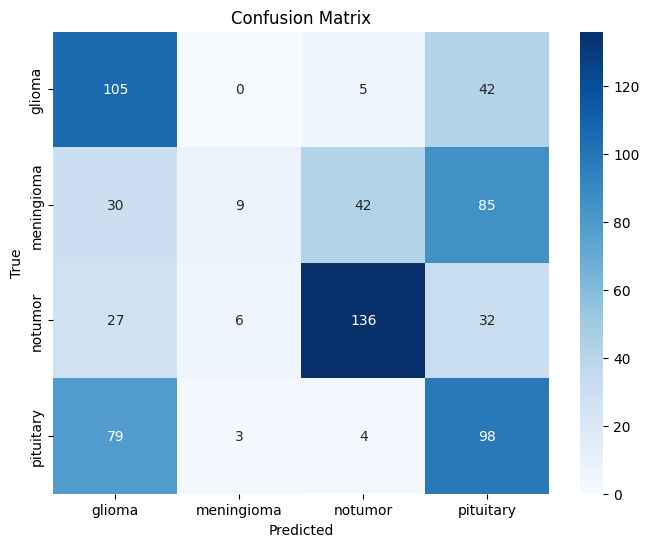

In [15]:
# Cell 8
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the best model weights
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate and print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Cell 4 (Final Corrected Version)
import os
import shutil

# Define paths
original_training_dir = 'Training'
original_testing_dir = 'Testing'
combined_dir = 'all_images'
# These are the correct folder names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create the new combined directory structure
if os.path.exists(combined_dir):
    shutil.rmtree(combined_dir) # Remove old directory if it exists
os.makedirs(combined_dir)
for cls in classes:
    os.makedirs(os.path.join(combined_dir, cls))

# Function to copy files
def copy_files(source_dir):
    for cls in classes:
        source_cls_dir = os.path.join(source_dir, cls)
        dest_cls_dir = os.path.join(combined_dir, cls)

        if os.path.exists(source_cls_dir):
            for filename in os.listdir(source_cls_dir):
                shutil.copy(os.path.join(source_cls_dir, filename), dest_cls_dir)
        else:
            print(f"Warning: Source directory not found at '{source_cls_dir}'")

# Copy files from both Training and Testing directories
print("Starting file copy to consolidate images...")
copy_files(original_training_dir)
copy_files(original_testing_dir)
print("All images have been successfully consolidated.")

Starting file copy to consolidate images...
All images have been successfully consolidated.


In [14]:
 #Cell 5 (Updated with Smaller Batch Size)
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire consolidated dataset
full_dataset = datasets.ImageFolder(combined_dir)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create new dataset instances for each split with the correct transform
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, transform=train_transform)
val_dataset = TransformedDataset(val_subset, transform=val_test_transform)
test_dataset = TransformedDataset(test_subset, transform=val_test_transform)

# Create DataLoaders
BATCH_SIZE = 8 # Using batch size 8 as determined by memory constraints
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Store class names
class_names = full_dataset.classes

print(f"Class names: {class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training set size: 5618
Validation set size: 702
Test set size: 703


In [16]:
# Cell 6 (DeiT Version)
import timm
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the DeiT Model with Transfer Learning
model = timm.create_model(
    'deit_tiny_patch16_224',  # The model for this experiment
    pretrained=True,
    num_classes=len(class_names)
)
model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [18]:
# Cell 7 (for training DeiT)
import time
from tqdm.auto import tqdm

NUM_EPOCHS = 20
# --- IMPORTANT: New name for the saved MaxViT model ---
BEST_MODEL_PATH = 'best_model_deit_tl.pth'
best_val_accuracy = 0.0

# The history dictionary stores the metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    epoch_train_loss = train_loss / train_total
    epoch_train_acc = 100 * train_correct / train_total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_acc = 100 * val_correct / val_total
    epoch_val_loss = val_loss / val_total
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Print comprehensive results for the epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {epoch_val_acc:.2f}% | "
          f"Duration: {epoch_duration:.2f}s")

    # Save the best model based on validation accuracy
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with validation accuracy: {best_val_accuracy:.2f}%")

print("\nFinished Training")
print(f"Best validation accuracy achieved: {best_val_accuracy:.2f}%")

Epoch 1/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 1/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/20 -> Train Loss: 0.0504, Train Acc: 98.22% | Val Loss: 0.1528, Val Acc: 95.30% | Duration: 49.73s
🎉 New best model saved with validation accuracy: 95.30%


Epoch 2/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 2/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/20 -> Train Loss: 0.0418, Train Acc: 98.58% | Val Loss: 0.1472, Val Acc: 95.58% | Duration: 48.62s
🎉 New best model saved with validation accuracy: 95.58%


Epoch 3/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 3/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/20 -> Train Loss: 0.0386, Train Acc: 98.68% | Val Loss: 0.1017, Val Acc: 96.87% | Duration: 48.93s
🎉 New best model saved with validation accuracy: 96.87%


Epoch 4/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 4/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/20 -> Train Loss: 0.0370, Train Acc: 98.84% | Val Loss: 0.0956, Val Acc: 96.87% | Duration: 48.85s


Epoch 5/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 5/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/20 -> Train Loss: 0.0353, Train Acc: 98.83% | Val Loss: 0.0652, Val Acc: 97.86% | Duration: 48.84s
🎉 New best model saved with validation accuracy: 97.86%


Epoch 6/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 6/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/20 -> Train Loss: 0.0322, Train Acc: 99.09% | Val Loss: 0.0850, Val Acc: 97.29% | Duration: 49.00s


Epoch 7/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 7/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/20 -> Train Loss: 0.0355, Train Acc: 98.99% | Val Loss: 0.0988, Val Acc: 97.15% | Duration: 50.13s


Epoch 8/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 8/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/20 -> Train Loss: 0.0364, Train Acc: 98.84% | Val Loss: 0.0633, Val Acc: 98.15% | Duration: 48.69s
🎉 New best model saved with validation accuracy: 98.15%


Epoch 9/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 9/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/20 -> Train Loss: 0.0254, Train Acc: 99.29% | Val Loss: 0.0546, Val Acc: 98.29% | Duration: 48.94s
🎉 New best model saved with validation accuracy: 98.29%


Epoch 10/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 10/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/20 -> Train Loss: 0.0336, Train Acc: 98.83% | Val Loss: 0.0725, Val Acc: 97.44% | Duration: 48.83s


Epoch 11/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 11/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/20 -> Train Loss: 0.0355, Train Acc: 98.75% | Val Loss: 0.1124, Val Acc: 96.01% | Duration: 48.89s


Epoch 12/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 12/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/20 -> Train Loss: 0.0349, Train Acc: 98.75% | Val Loss: 0.0649, Val Acc: 98.29% | Duration: 48.75s


Epoch 13/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 13/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/20 -> Train Loss: 0.0233, Train Acc: 99.25% | Val Loss: 0.0683, Val Acc: 97.44% | Duration: 50.38s


Epoch 14/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 14/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/20 -> Train Loss: 0.0307, Train Acc: 98.91% | Val Loss: 0.1067, Val Acc: 96.58% | Duration: 48.82s


Epoch 15/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 15/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/20 -> Train Loss: 0.0348, Train Acc: 98.86% | Val Loss: 0.0781, Val Acc: 98.01% | Duration: 48.64s


Epoch 16/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 16/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16/20 -> Train Loss: 0.0257, Train Acc: 99.18% | Val Loss: 0.0808, Val Acc: 98.58% | Duration: 49.61s
🎉 New best model saved with validation accuracy: 98.58%


Epoch 17/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 17/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17/20 -> Train Loss: 0.0267, Train Acc: 99.07% | Val Loss: 0.0843, Val Acc: 97.72% | Duration: 49.59s


Epoch 18/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 18/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18/20 -> Train Loss: 0.0292, Train Acc: 99.16% | Val Loss: 0.0774, Val Acc: 97.44% | Duration: 49.12s


Epoch 19/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 19/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19/20 -> Train Loss: 0.0282, Train Acc: 99.15% | Val Loss: 0.0743, Val Acc: 97.29% | Duration: 50.18s


Epoch 20/20 [Training]:   0%|          | 0/703 [00:00<?, ?it/s]

Epoch 20/20 [Validation]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20/20 -> Train Loss: 0.0162, Train Acc: 99.45% | Val Loss: 0.1035, Val Acc: 96.72% | Duration: 50.41s

Finished Training
Best validation accuracy achieved: 98.58%


Evaluating on Test Set:   0%|          | 0/88 [00:00<?, ?it/s]


           Final Classification Report (DeiT Model)

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       152
  meningioma       0.97      0.98      0.98       166
     notumor       0.99      0.99      0.99       201
   pituitary       0.98      0.99      0.99       184

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



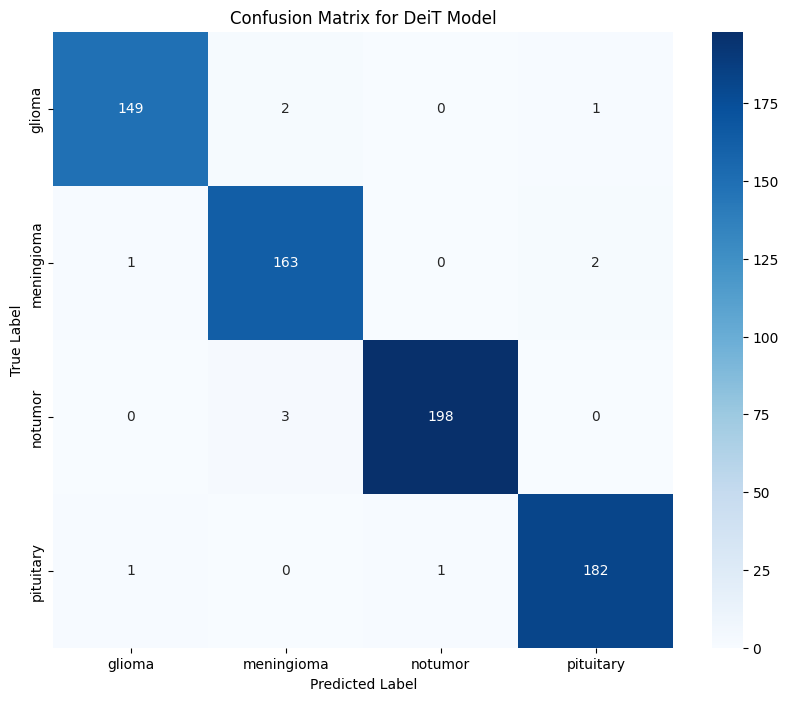

In [19]:
# Cell 8
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import timm
from tqdm.auto import tqdm

# --- Step 1: Re-create the model architecture ---
# We need to create an instance of the model first, then load the saved weights into it.
model = timm.create_model(
    'deit_tiny_patch16_224',
    pretrained=False,  # No need to download weights again, we are loading our own
    num_classes=len(class_names)
)

# --- Step 2: Load the saved weights ---
# Make sure this path matches the name you used in Cell 7 for the MaxViT model
MODEL_PATH = 'best_model_deit_tl.pth'
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval() # Set the model to evaluation mode

# --- Step 3: Run inference on the test set ---
y_true = []
y_pred = []

# We don't need to calculate gradients for evaluation, so we use torch.no_grad()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append batch results to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# --- Step 4: Generate and print the results ---

# Generate and print the classification report
print("\n" + "="*60)
print("           Final Classification Report (DeiT Model)")
print("="*60 + "\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for DeiT Model')
plt.show()